# GLORYS

In [1]:
import copernicusmarine
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas
import cmocean.cm as cmo
import glob
from scipy.stats import linregress
import cartopy
import gsw
from datetime import timedelta as delta


from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)



## Load Caribbean shapefile for more precise clipping
#fname = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/iho/iho.shp'
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/carib/new.shp'
carib = geopandas.read_file(fname)


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# copernicusmarine.login()

In [3]:
# years = np.arange(1993,2023,1)

# for year in years:
#     if year < 2021:
#         ds_id = "cmems_mod_glo_phy_my_0.083deg_P1M-m"
#     elif year > 2021:
#         ds_id = "cmems_mod_glo_phy_myint_0.083deg_P1M-m"
    
#     start_datetime = ''.join([str(year),"-01-01T00:00:00"])
#     end_datetime   = ''.join([str(year),"-12-31T00:00:00"])
    
    
#     ds = copernicusmarine.open_dataset(
#       dataset_id=ds_id,
#       dataset_version="202311",
#       variables=["so","thetao","uo","vo"],
#       minimum_longitude=-90,
#       maximum_longitude=-58,
#       minimum_latitude=8,
#       maximum_latitude=25,
#       start_datetime=start_datetime,
#       end_datetime=end_datetime,
#       maximum_depth=1100
#     )
    
#     ## Dask-ify
#     chunked = ds.chunk({"latitude": "auto", "longitude": "auto", "depth": "auto"})
#     ## Clip to Caribbean shapefile, this will actually shorten the lat and lon coordinates which is why I went to a bigger extent above
#     chunked = chunked.rio.write_crs('WGS84', inplace=True)
#     chunked = chunked.rio.clip(carib.geometry.values, carib.crs)
#     ## Save yearly mean
    
#     save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Mean_GLORYS_Carib_',str(year),'.nc'])
#     chunked.groupby(chunked.time.dt.year).mean().to_netcdf(save_fname)
#     print(''.join(['Done: ',str(year)]))


## 2021 is stupid and special

In [4]:
# ds1 = copernicusmarine.open_dataset(
#   dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m",
#   dataset_version="202311",
#   variables=["so","thetao","uo","vo"],
#   minimum_longitude=-90,
#   maximum_longitude=-58,
#   minimum_latitude=8,
#   maximum_latitude=25,
#   start_datetime="2021-01-01T00:00:00",
#   end_datetime="2021-12-31T00:00:00",
#   maximum_depth=1100
# )

# ds2 = copernicusmarine.open_dataset(
#   dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1M-m",
#   dataset_version="202311",
#   variables=["so","thetao","uo","vo"],
#   minimum_longitude=-90,
#   maximum_longitude=-58,
#   minimum_latitude=8,
#   maximum_latitude=25,
#   start_datetime="2021-01-01T00:00:00",
#   end_datetime="2021-12-31T00:00:00",
#   maximum_depth=1100
# )


# # ## Dask-ify
# chunked1 = ds1.chunk({"latitude": "auto", "longitude": "auto", "depth": "auto"})
# chunked2 = ds2.chunk({"latitude": "auto", "longitude": "auto", "depth": "auto"})


# # ## Combine
# ds = xr.merge([chunked1,chunked2])

# # ## Clip to Caribbean shapefile, this will actually shorten the lat and lon coordinates which is why I went to a bigger extent above
# chunked = ds.rio.write_crs('WGS84', inplace=True)
# chunked = chunked.rio.clip(carib.geometry.values, carib.crs)
# ## Save yearly mean

# save_fname = ''.join(['/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Mean_GLORYS_Carib_',str(2021),'.nc'])
# chunked.groupby(chunked.time.dt.year).mean().to_netcdf(save_fname)


## Load all

In [2]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/*.nc')
ds = xr.open_mfdataset(fnames)

## Convert to TEOS-10
pressure = gsw.p_from_z(-ds.depth,ds.latitude)
ds['absolute_salinity'] = gsw.SA_from_SP(ds.so, pressure, ds.longitude, ds.latitude)    
ds['conservative_temperature'] = gsw.CT_from_pt(ds.so, ds.thetao)
## Update attributes
ds.absolute_salinity.attrs['long_name'] = 'Absolute Salinity'
ds.absolute_salinity.attrs['unit_long'] = 'Absolute Salinity'
ds.absolute_salinity.attrs['units'] = 'g kg$^{-1}$'
ds.conservative_temperature.attrs['long_name'] = 'Conservative Temperature'
ds.conservative_temperature.attrs['unit_long'] = 'Conservative Temperature'
ds.conservative_temperature.attrs['units'] = '°C'


ds

<xarray.Dataset>
Dimensions:                   (depth: 36, latitude: 177, longitude: 359,
                               year: 30)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 902.3 1.062e+03
  * latitude                  (latitude) float32 8.0 8.083 8.167 ... 22.58 22.67
  * longitude                 (longitude) float32 -89.33 -89.25 ... -59.58 -59.5
    spatial_ref               int64 0
  * year                      (year) int64 1993 1994 1995 ... 2020 2021 2022
Data variables:
    so                        (year, depth, latitude, longitude) float32 dask.array<chunksize=(1, 36, 177, 359), meta=np.ndarray>
    thetao                    (year, depth, latitude, longitude) float32 dask.array<chunksize=(1, 36, 177, 359), meta=np.ndarray>
    uo                        (year, depth, latitude, longitude) float32 dask.array<chunksize=(1, 36, 177, 359), meta=np.ndarray>
    vo                        (year, depth, latitude, longitude) float32 dask.array<chunksize=(1, 36, 177, 359), meta=np.ndarray>
    absolute_salinity         (year, depth, latitude, longitude) float64 dask.array<chunksize=(1, 36, 177, 359), meta=np.ndarray>
    conservative_temperature  (year, depth, latitude, longitude) float64 dask.array<chunksize=(1, 36, 177, 359), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

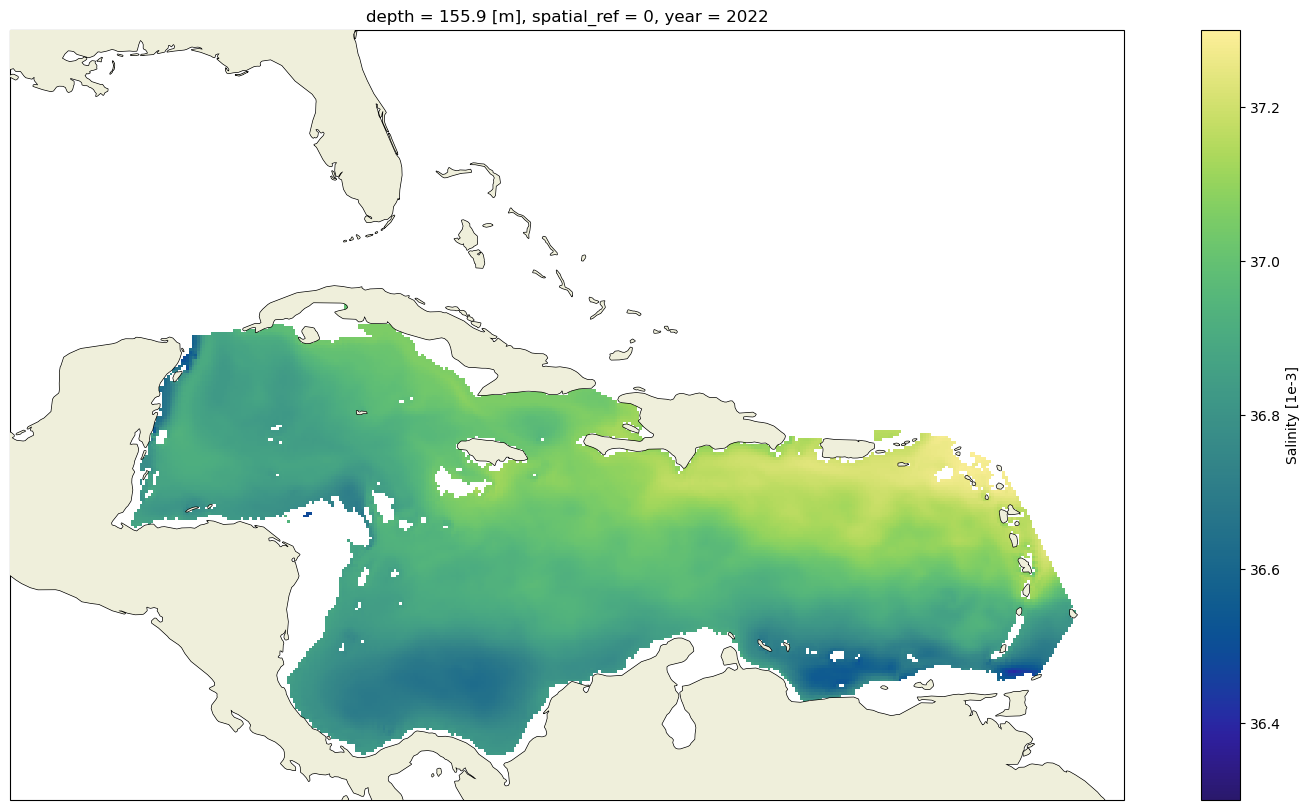

In [6]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
ds.so.isel(year=-1,depth=24).plot(vmin=36.3,vmax=37.3,cmap=cmo.haline)

########################################################################################################
ax.set_extent([-92, -58, 7.5, 30])
ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)